In [671]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [672]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [673]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


In [674]:
seq_len = 12

Load and prepare data


Create a unique location identifier and time key


In [675]:
data = pd.read_csv("./data/rnn_full_data.csv")
min_year = np.min(data["Year"].unique())
data["time_key"] = (data["Year"] - min_year) * 12 + data["Month"] - 1
n_times = data["time_key"].nunique()
data["location_key"] = data["Location Group"] + "_" + data["District"].astype(str)
data = pd.get_dummies(data, columns=["Location Group", "District"])
location2idx = {location: i for i, location in enumerate(data["location_key"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_key"].unique())}
data["location_id"] = data["location_key"].map(location2idx)

In [676]:
features = ["crime_count", "sin_month", "cos_month", "holiday_count"]
pivot_df = data.pivot(
    index="time_key",
    columns="location_id",
    values="crime_count",
)
pivot_df = pivot_df.fillna(0)  # handle missing values if necessary
# n_feature = pivot_df.columns.get_level_values(0).nunique()
n_location = pivot_df.columns.get_level_values(0).nunique()
time_features = pd.DataFrame(index=pivot_df.index)
time_features["holiday_count"] = data.groupby("time_key")["holiday_count"].first()
time_features["sin_month"] = data.groupby("time_key")["sin_month"].first()
time_features["cos_month"] = data.groupby("time_key")["cos_month"].first()
train_size = int((len(pivot_df) - seq_len) * 0.75)
pivot_df.shape, time_features.shape

((84, 251), (84, 3))

In [677]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pivot_df.copy()
scaler = MinMaxScaler()
print(scaled_df.shape)
scaled_df[: train_size + seq_len] = scaler.fit_transform(
    scaled_df[: train_size + seq_len]
)
scaled_df[train_size + seq_len :] = scaler.transform(scaled_df[train_size + seq_len :])
scaled_df = pd.DataFrame(scaled_df, columns=pivot_df.columns)

(84, 251)


In [678]:
def create_sequences(crime_counts_df, time_features_df, seq_length=12):
    X_seq = []
    y_vals = []
    loc_idx = []
    time_idx = []
    T = crime_counts_df.shape[0]
    location_ids = crime_counts_df.columns
    for col in location_ids:
        crime_series = crime_counts_df[col].values
        for i in range(T - seq_length):
            crime_window = crime_series[i : i + seq_length].reshape(
                -1, 1
            )  # shape (seq_length, 1)
            tf_window = time_features_df.iloc[i : i + seq_length].values
            window_features = np.hstack([crime_window, tf_window])
            y_val = crime_series[i + seq_length]
            X_seq.append(window_features)
            y_vals.append(y_val)
            loc_idx.append(col)
            time_idx.append(i)
    X_seq = np.array(X_seq)  # shape => (#samples, seq_length, 4)
    y_vals = np.array(y_vals)  # shape => (#samples,)
    loc_idx = np.array(loc_idx)  # shape => (#samples,)
    time_idx = np.array(time_idx)  # shape => (#samples,)
    return X_seq, y_vals, loc_idx, time_idx


seq_length = 12
X_seq, y, loc_idx, time_idx = create_sequences(
    scaled_df, time_features, seq_length=seq_length
)
n_feature = X_seq.shape[2]

print("X_seq shape:", X_seq.shape)  # (#samples, seq_length, n_feature)
print("y shape:", y.shape)  # (#samples,)
print("loc_idx shape:", loc_idx.shape)  # (#samples,)
print("time_idx shape:", time_idx.shape)  # (#samples,)

X_seq shape: (18072, 12, 4)
y shape: (18072,)
loc_idx shape: (18072,)
time_idx shape: (18072,)


In [679]:
train_mask = time_idx < train_size
test_mask = time_idx >= train_size

X_train = X_seq[train_mask]
y_train = y[train_mask]
loc_train = loc_idx[train_mask]
time_train = time_idx[train_mask]

X_test = X_seq[test_mask]
y_test = y[test_mask]
loc_test = loc_idx[test_mask]
time_test = time_idx[test_mask]

print("Train shapes:", X_train.shape, loc_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, loc_test.shape, y_test.shape)

Train shapes: (13554, 12, 4) (13554,) (13554,)
Test shapes: (4518, 12, 4) (4518,) (4518,)


In [680]:
from torch.utils.data import Dataset, DataLoader


class CrimeDataset(Dataset):
    def __init__(self, X, y, loc_idx, time_idx):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx
        self.time_idx = time_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        time_idx = torch.tensor(self.time_idx[idx], dtype=torch.long)
        return X, y, loc_idx, time_idx

In [ ]:
num_size = n_feature
cat_size = n_location
batch_size = 128
hidden_size = 128
num_layers = 3
embed_dim = 16
output_size = 1
num_epochs = 50
dropout = 0.3
learning_rate = 0.01

In [682]:
train_dataset = CrimeDataset(X_train, y_train, loc_train, time_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CrimeDataset(X_test, y_test, loc_test, time_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [683]:
for X_batch, y_batch, loc_batch, time_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    print(f"loc_batch shape: {loc_batch.shape}")
    print(f"time_batch shape: {time_batch.shape}")
    break

X_batch shape: torch.Size([128, 12, 4])
y_batch shape: torch.Size([128])
loc_batch shape: torch.Size([128])
time_batch shape: torch.Size([128])


In [684]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, X, loc, h_0, c_0):
        """
        x: [batch_size, seq_len, n_feature]
        h_0, c_0: [num_layers, batch_size, hidden_size]
        output: [batch_size, n_location, output_size]
        """
        _, seq_len, _ = X.shape
        loc_embed = self.embedding(loc)
        loc_embed = loc_embed.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_input = torch.cat((X, loc_embed), dim=2)
        lstm_output, (h_n, c_n) = self.lstm(lstm_input, (h_0, c_0))
        last_output = lstm_output[:, -1, :]
        fc_out = self.fc1(last_output)
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        fc_out = self.fc2(fc_out)  # [batch_size*n_location, output_size]
        return fc_out, (h_n, c_n)

In [685]:
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

CrimeLSTM(
  (embedding): Embedding(251, 16)
  (lstm): LSTM(20, 128, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define loss function and optimizer


In [686]:
criterion = nn.MSELoss()

Training function


In [687]:
# Validation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for X_batch, y_batch, loc_batch, _ in test_loader:
            X_batch, y_batch, loc_batch = (
                X_batch.to(device),
                y_batch.to(device),
                loc_batch.to(device),
            )
            curr_batch_size = X_batch.shape[0]
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.view(curr_batch_size)
            loss = criterion(score, y_batch)
            val_loss += loss.item()
            num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [688]:
start_time = time.time()
train_losses = []
val_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # because we're monitoring loss
    factor=0.1,  # how much to reduce the LR
    patience=5,  # how many epochs to wait
    threshold=1e-4,  # min improvement to be considered
    cooldown=0,  # cooldown after reduction
    min_lr=1e-6,  # don’t go below this
)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for X_batch, y_batch, loc_batch, _ in train_loader:
        optimizer.zero_grad()
        curr_batch_size = X_batch.shape[0]
        X_batch, y_batch, loc_batch = (
            X_batch.to(device),
            y_batch.to(device),
            loc_batch.to(device),
        )
        h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        score, (_, _) = model(X_batch, loc_batch, h, c)
        score = score.reshape(curr_batch_size)
        loss = criterion(score, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, LR: {scheduler.get_last_lr()[0]:.12f}"
    )

Epoch [1/50], Train Loss: 0.064265465048, Val Loss: 0.055555480817, LR: 0.010000000000
Epoch [2/50], Train Loss: 0.039763667340, Val Loss: 0.050766651467, LR: 0.010000000000
Epoch [3/50], Train Loss: 0.037615588901, Val Loss: 0.044893592596, LR: 0.010000000000
Epoch [4/50], Train Loss: 0.036802326540, Val Loss: 0.041047304067, LR: 0.010000000000
Epoch [5/50], Train Loss: 0.035744711036, Val Loss: 0.043481651590, LR: 0.010000000000
Epoch [6/50], Train Loss: 0.035030363303, Val Loss: 0.040455019981, LR: 0.010000000000
Epoch [7/50], Train Loss: 0.034350901825, Val Loss: 0.045051924212, LR: 0.010000000000
Epoch [8/50], Train Loss: 0.032744084362, Val Loss: 0.044099918774, LR: 0.010000000000
Epoch [9/50], Train Loss: 0.032096890645, Val Loss: 0.046752139279, LR: 0.010000000000
Epoch [10/50], Train Loss: 0.031754348128, Val Loss: 0.042844719978, LR: 0.010000000000
Epoch [11/50], Train Loss: 0.030878685555, Val Loss: 0.046891113174, LR: 0.010000000000
Epoch [12/50], Train Loss: 0.030085650782

Train the model


Plot training and validation loss


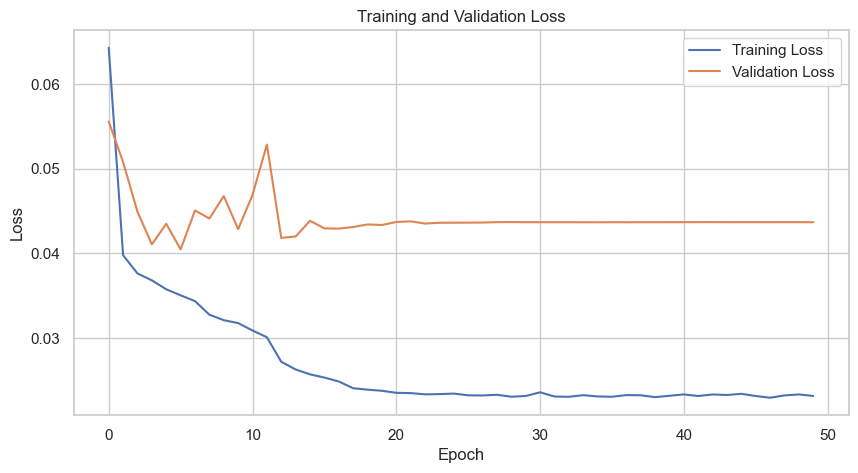

In [689]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("./figure/training_validation_loss.pdf", format="pdf")
plt.show()

In [690]:
def predictions(model, train_loader, test_loader):
    result = np.zeros(
        (
            (len(train_loader.dataset) + len(test_loader.dataset)) // n_location,
            n_location,
            2,
        )
    )

    def get_result(result, loader):
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch, loc_batch, time_batch) in enumerate(loader):
                curr_batch_size = X_batch.shape[0]
                X_batch, y_batch, loc_batch = (
                    X_batch.to(device),
                    y_batch.to(device),
                    loc_batch.to(device),
                )
                h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                score, (_, _) = model(X_batch, loc_batch, h, c)
                score = score.reshape(curr_batch_size)
                result[time_batch, loc_batch.cpu().numpy(), 0] = score.cpu().numpy()
                result[time_batch, loc_batch.cpu().numpy(), 1] = y_batch.cpu().numpy()

    get_result(result, train_loader)
    get_result(result, test_loader)
    return result

In [691]:
result = predictions(model, train_loader, test_loader)
result_unscaled = np.zeros(result.shape)
result_unscaled[:, :, 0] = scaler.inverse_transform(result[:, :, 0])
result_unscaled[:, :, 1] = scaler.inverse_transform(result[:, :, 1])
result_unscaled = np.round(result_unscaled).astype(int)
result_df = data.copy()
result_df["lstm_prediction"] = np.nan
for i in range(len(result_unscaled)):
    for j in range(len(result_unscaled[i])):
        result_df.loc[
            (result_df["time_key"] == i + seq_length) & (result_df["location_id"] == j),
            "lstm_prediction",
        ] = result_unscaled[i, j, 0]

In [692]:
result_df = result_df[result_df["time_key"] > seq_length - 1]
result_df.to_csv("./data/lstm_predictions.csv", index=False)

In [693]:
result_df[["Year", "Month", "location_key", "crime_count", "lstm_prediction"]].head(12)

,Year,Month,location_key,crime_count,lstm_prediction
2900,2019,1,EDUCATIONAL_1.0,22.0,19.0
2901,2019,1,FINANCIAL_1.0,21.0,16.0
2902,2019,1,FOOD_ENTERTAINMENT_1.0,185.0,168.0
2903,2019,1,GOVERNMENT_1.0,11.0,16.0
2904,2019,1,OFFICE_BUSINESS_1.0,40.0,36.0
2905,2019,1,OTHER_1.0,128.0,137.0
2906,2019,1,PARKING_1.0,74.0,65.0
2907,2019,1,RESIDENTIAL_1.0,86.0,118.0
2908,2019,1,RETAIL_1.0,260.0,247.0
2909,2019,1,STREET_OUTDOOR_1.0,170.0,211.0


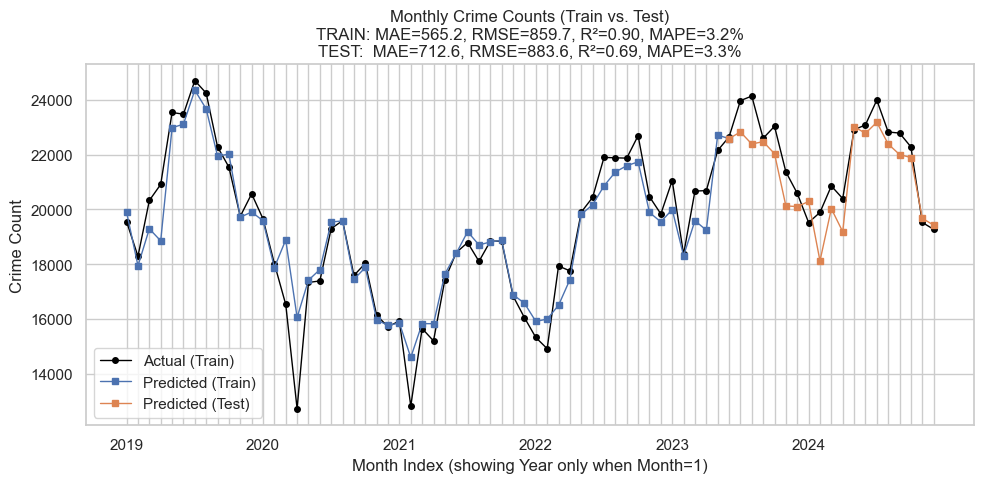

In [694]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


def mean_absolute_percentage_error(y_true, y_pred):
    """Compute MAPE safely, avoiding division by zero."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


monthly_agg = result_df.groupby(["Year", "Month"], as_index=False).agg(
    {"crime_count": "sum", "lstm_prediction": "sum"}
)

monthly_agg.sort_values(["Year", "Month"], inplace=True)

y_true = monthly_agg["crime_count"].values
y_pred = monthly_agg["lstm_prediction"].values

x_vals = np.arange(len(monthly_agg))

cutoff = train_size
train_mask = x_vals < cutoff
test_mask = x_vals >= cutoff - 1
y_true_train, y_pred_train = y_true[train_mask], y_pred[train_mask]
y_true_test, y_pred_test = y_true[test_mask], y_pred[test_mask]

mae_train = mean_absolute_error(y_true_train, y_pred_train)
rmse_train = root_mean_squared_error(y_true_train, y_pred_train)
r2_train = r2_score(y_true_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_true_train, y_pred_train)

mae_test = mean_absolute_error(y_true_test, y_pred_test)
rmse_test = root_mean_squared_error(y_true_test, y_pred_test)
r2_test = r2_score(y_true_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test)
labels = []
for _, row in monthly_agg.iterrows():
    year = row["Year"]
    month = row["Month"]
    if month == 1:
        labels.append(int(year))  # show the year for January
    else:
        labels.append("")  # show empty for other months
plt.figure(figsize=(10, 5))

# Actual - Train portion
plt.plot(
    x_vals,
    y_true,
    marker="o",
    label="Actual (Train)",
    color="black",
    markersize=4,
    linewidth=1,
)
plt.plot(
    x_vals[train_mask],
    y_pred[train_mask],
    marker="s",
    label="Predicted (Train)",
    markersize=4,
    linewidth=1,
)
plt.plot(
    x_vals[test_mask],
    y_pred[test_mask],
    marker="s",
    label="Predicted (Test)",
    linestyle="-",
    markersize=4,
    linewidth=1,
)

plt.title(
    "Monthly Crime Counts (Train vs. Test)\n"
    "TRAIN: "
    f"MAE={mae_train:.1f}, RMSE={rmse_train:.1f}, R²={r2_train:.2f}, MAPE={mape_train:.1f}%\n"
    "TEST:  "
    f"MAE={mae_test:.1f}, RMSE={rmse_test:.1f}, R²={r2_test:.2f}, MAPE={mape_test:.1f}%"
)

plt.xlabel("Month Index (showing Year only when Month=1)")
plt.ylabel("Crime Count")
plt.xticks(x_vals, labels, rotation=0)  # Use custom labels
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

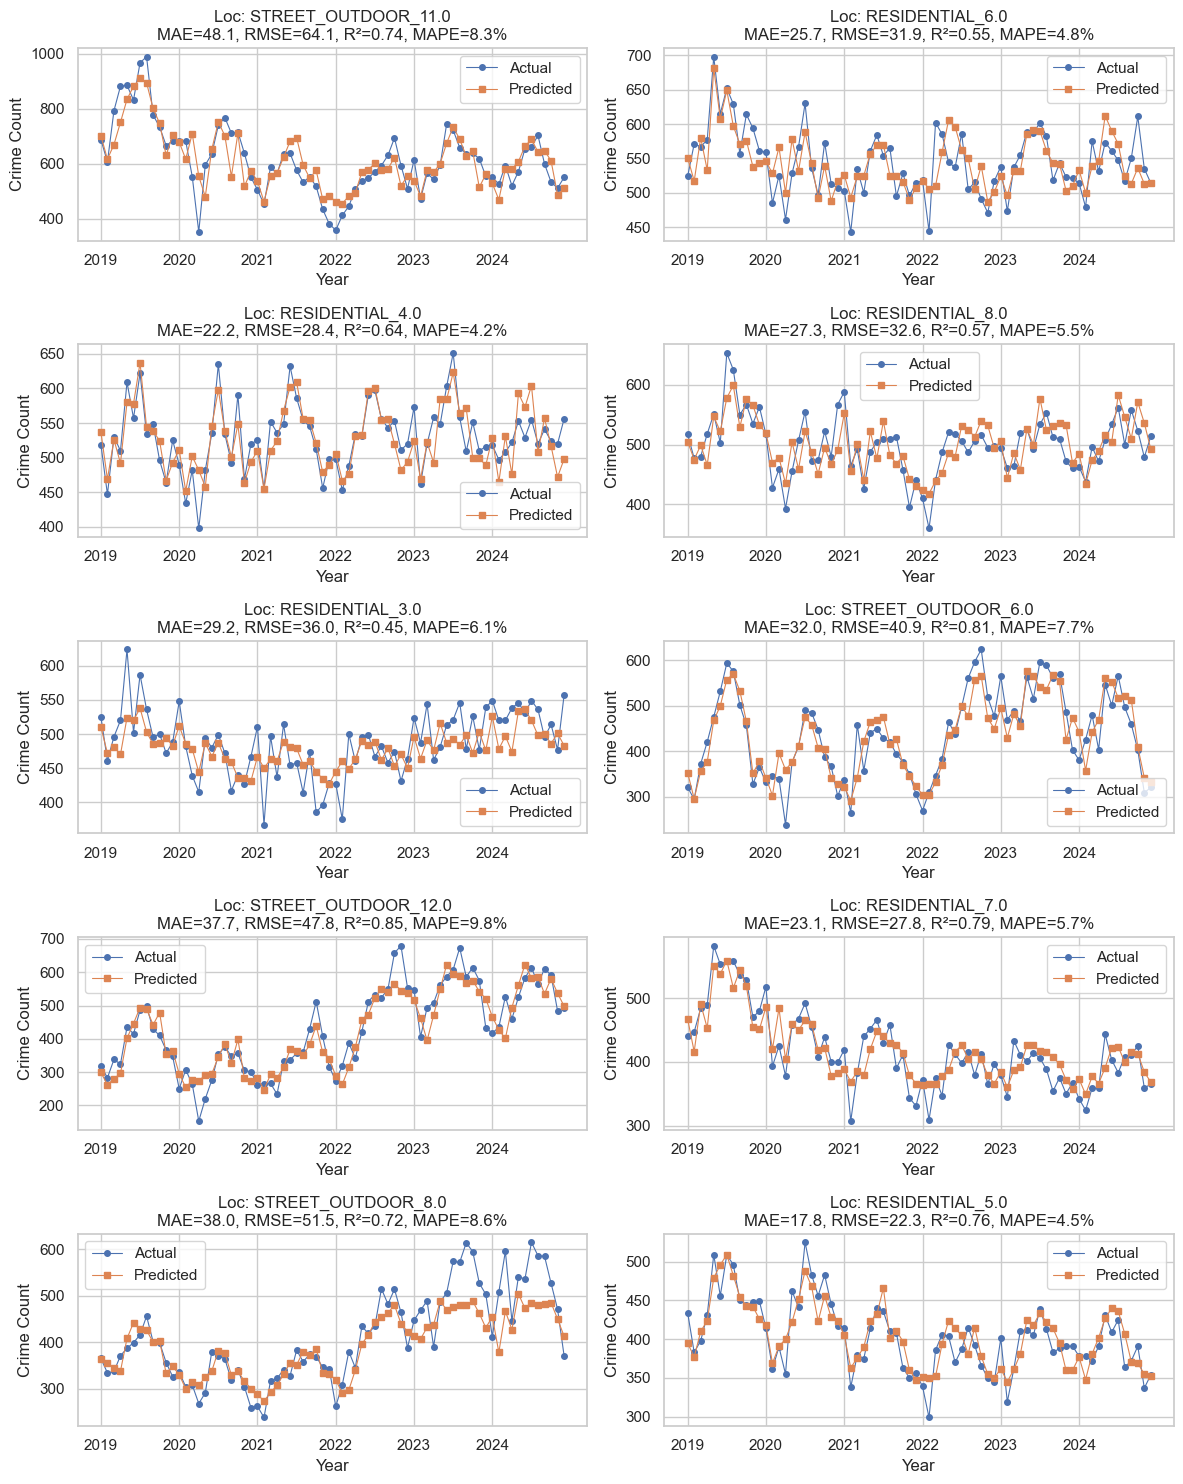

In [695]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def mape(y_true, y_pred):
    """Compute Mean Absolute Percentage Error."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


df = result_df.copy()
df.sort_values(["location_key", "Year", "Month"], inplace=True)
total_by_loc = (
    df.groupby("location_key")["crime_count"].sum().sort_values(ascending=False)
)
top_locations = total_by_loc.index[:10]
df_top = df[df["location_key"].isin(top_locations)].copy()
df_top.sort_values(["location_key", "Year", "Month"], inplace=True)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axes = axes.flatten()
for i, loc in enumerate(top_locations):
    df_loc = df_top[df_top["location_key"] == loc].copy()
    df_loc.sort_values(["Year", "Month"], inplace=True)
    df_loc.reset_index(drop=True, inplace=True)  # reset index so x-axis is 0, 1, 2, ...
    x_vals = df_loc.index  # Each index represents one month
    actual = df_loc["crime_count"].values
    predicted = df_loc["lstm_prediction"].values
    mae_val = mean_absolute_error(actual, predicted)
    rmse_val = np.sqrt(mean_squared_error(actual, predicted))
    r2_val = r2_score(actual, predicted)
    mape_val = mape(actual, predicted)
    ax = axes[i]
    ax.plot(x_vals, actual, marker="o", markersize=4, linewidth=0.8, label="Actual")
    ax.plot(
        x_vals, predicted, marker="s", markersize=4, linewidth=0.8, label="Predicted"
    )
    ax.set_title(
        f"Loc: {loc}\nMAE={mae_val:.1f}, RMSE={rmse_val:.1f}, R²={r2_val:.2f}, MAPE={mape_val:.1f}%"
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("Crime Count")
    unique_years = df_loc["Year"].unique()
    tick_positions = []
    tick_labels = []
    for year in unique_years:
        pos = df_loc[df_loc["Year"] == year].index[0]
        tick_positions.append(pos)
        tick_labels.append(str(year))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.legend()

plt.tight_layout()
plt.show()